# Cloud masking with Sentinel Hub and s2cloudless

Notebook showing how to get cloud masks from [Sentinel Hub services](https://medium.com/sentinel-hub/cloud-masks-at-your-service-6e5b2cb2ce8a), or compute them locally using `mask.eotask_cloud_mask` module.

In [1]:
%matplotlib inline

import os
import datetime as datetime

import matplotlib.pyplot as plt
import numpy as np

from eolearn.core import FeatureType, EOWorkflow, EONode, SaveTask, OverwritePermission, EOPatch
from eolearn.io import SentinelHubInputTask
from eolearn.mask import CloudMaskTask
from sentinelhub import CRS, BBox, DataCollection

/home/jgersak/Documents/Projects/NotebookUpdate/Example1/example1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define ROI BBOX, time interval, select a sample index in time indices and folder where EOPatchs are going to be saved in this case a bounding box around Ljubljana, February - May 2020, 11 timestamp index and folder `eopatches`
in curent directory.

In [2]:
roi_bbox = BBox([14.218369, 46.007455, 14.71344, 46.271275], crs=CRS.WGS84)

time_interval = ("2020-02-01", "2020-05-01")

timestamp_idx = 11

eopatch_folder = os.path.join(".", "eopatches")

### Use Sentinel Hub precomputed cloud masks and cloud probabilities

This task will download RGB Sentinel-2 bands together with CLM and CLP bands. See [blog](https://medium.com/sentinel-hub/cloud-masks-at-your-service-6e5b2cb2ce8a) on cloud masks available on Sentinel Hub. 

The downloaded masks will be stored in 
  * `CLM` - cloud mask
  * `CLP` - cloud pseudo-probabilities

In [3]:
input_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands=["B02", "B03", "B04"],
    bands_feature=(FeatureType.DATA, "trueColorBands"),
    additional_data=[(FeatureType.MASK, "dataMask"), (FeatureType.MASK, "CLM"), (FeatureType.DATA, "CLP")],
    resolution=(160, 160),
    time_difference=datetime.timedelta(hours=2),
    max_threads=3,
)

In [4]:
%%time
eopatch = input_task.execute(bbox=roi_bbox, time_interval=time_interval)

CPU times: user 2.02 s, sys: 256 ms, total: 2.28 s
Wall time: 6.42 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


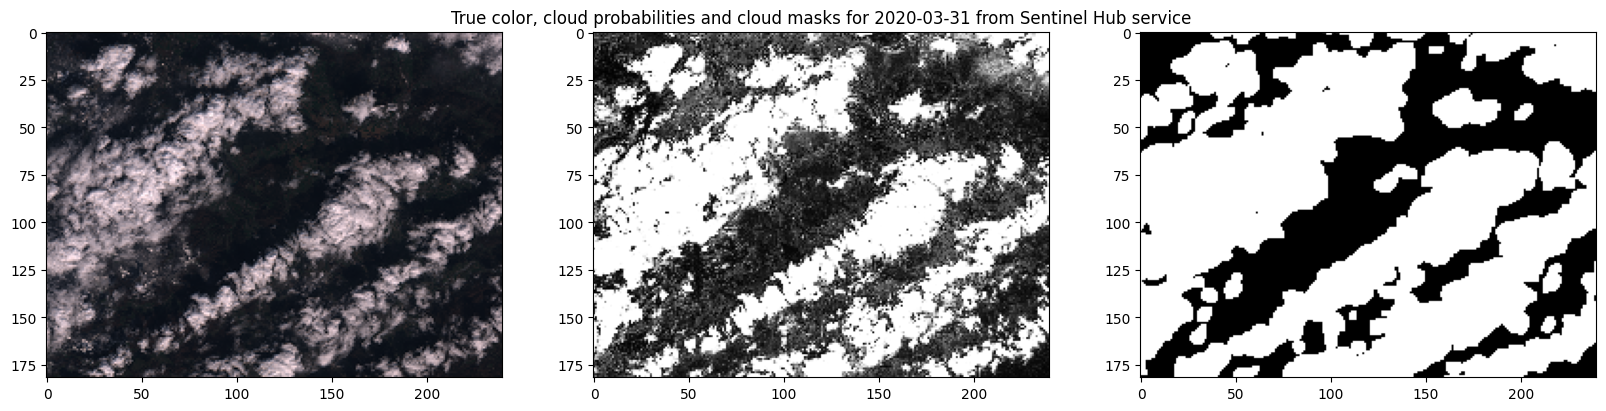

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
ax[0].imshow(eopatch.data["trueColorBands"][timestamp_idx][..., [2, 1, 0]])
ax[1].imshow(np.squeeze(eopatch.data["CLP"][timestamp_idx]), cmap="gray")
ax[2].imshow(np.squeeze(eopatch.mask["CLM"][timestamp_idx]), cmap="gray")

ax[1].set_title(
    f"True color, cloud probabilities and cloud masks for {eopatch.timestamp[timestamp_idx].date().isoformat()} from"
    " Sentinel Hub service"
);

### Compute cloud maps yourself

In this workflow example, the cloud maps are computed locally by requesting appropriate bands from service and running [S2Cloudless](https://github.com/sentinel-hub/sentinel2-cloud-detector).  

In [6]:
bands_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands=["B01", "B02", "B04", "B05", "B08", "B8A", "B09", "B10", "B11", "B12"],
    bands_feature=(FeatureType.DATA, "BANDS-S2-L1C"),
    additional_data=[(FeatureType.MASK, "dataMask")],
    resolution=(160, 160),
    time_difference=datetime.timedelta(hours=2),
    max_threads=3,
)

add_clm = CloudMaskTask(
    all_bands=False,
    is_data_feature=(FeatureType.MASK, "dataMask"),
    mono_features=("CLP", "CLM"),
    mask_feature=None,
    processing_resolution="160m",
)

save = SaveTask(eopatch_folder, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [7]:
bands_node = EONode(bands_task)

add_clm_node = EONode(add_clm, inputs=[bands_node])

save_node = EONode(save, inputs=[add_clm_node])

Run the whole workflow: download bands and execute `CloudMaskTask`:

In [8]:
%%time
workflow = EOWorkflow([bands_node, add_clm_node, save_node])
workflow.execute(input_kwargs={bands_node: {"bbox": roi_bbox, "time_interval": time_interval}})

eopatch_clm = EOPatch.load(eopatch_folder)

CPU times: user 24.8 s, sys: 434 ms, total: 25.2 s
Wall time: 12.7 s


Plot results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


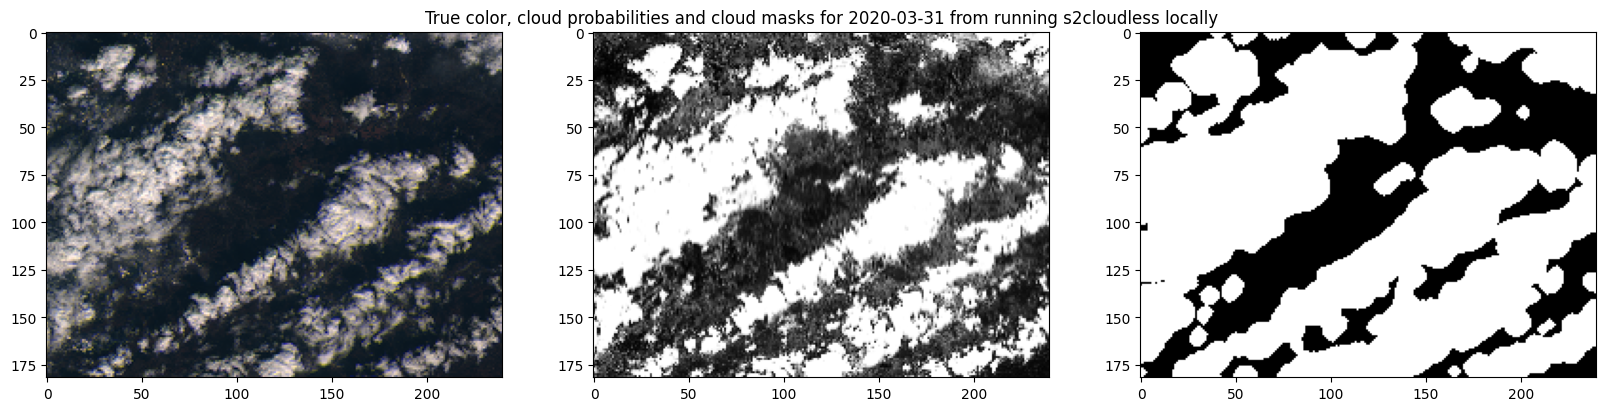

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
ax[0].imshow(eopatch_clm.data["BANDS-S2-L1C"][timestamp_idx][..., [2, 1, 0]])
ax[1].imshow(np.squeeze(eopatch_clm.data["CLP"][timestamp_idx]), cmap="gray")
ax[2].imshow(np.squeeze(eopatch_clm.mask["CLM"][timestamp_idx]), cmap="gray")

ax[1].set_title(
    f"True color, cloud probabilities and cloud masks for {eopatch.timestamp[timestamp_idx].date().isoformat()} from"
    " running s2cloudless locally"
);

### Multi-temporal cloud masks

The `CloudMaskTask` also supports multi-temporal cloud masking, taking several observations into account when calculating masks for any given observation. As we have already all the data available, we'll just create the task and execute it on the `eopatch`. For possible comparison with mono-temporal masks, we'll append the multi-temporal cloud masks and pseudoprobabilities with `_multi`. 

In [13]:
add_multitemporal_clm = CloudMaskTask(
    all_bands=False,
    is_data_feature=(FeatureType.MASK, "dataMask"),
    multi_features=("CLP_multi", "CLM_multi"),
    mask_feature=None,
    processing_resolution="160m",
)

In [14]:
%%time
eopatch_clm_multi = add_multitemporal_clm.execute(eopatch_clm)

CPU times: user 1min 20s, sys: 251 ms, total: 1min 21s
Wall time: 9.54 s


NameError: name 'eopatch_clm_multi' is not defined

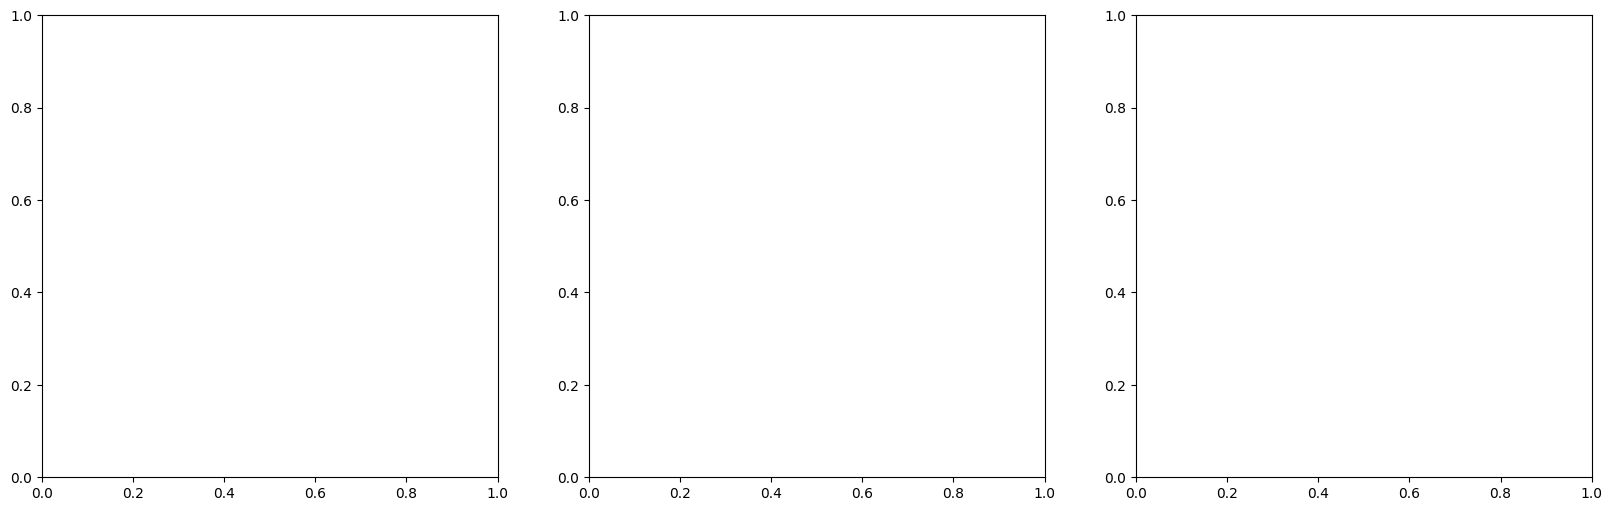

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
ax[0].imshow(eopatch_clm_multi.data["BANDS-S2-L1C"][timestamp_idx][..., [2, 1, 0]])
ax[1].imshow(np.squeeze(eopatch_clm_multi.data["CLP_multi"][timestamp_idx]), cmap="gray")
ax[2].imshow(np.squeeze(eopatch_clm_multi.mask["CLM_multi"][timestamp_idx]), cmap="gray")

ax[1].set_title(
    f"True color, cloud probabilities and cloud masks for {eopatch.timestamp[timestamp_idx].date().isoformat()} from"
    " running multi-temporal s2cloudless masking locally"
);

### Before you go

Using cloud masks provided by the service suffices for most use cases, driving down the cost of your processing while being faster. You might have noticed the `%%time` magic command used throughout the notebook; in my case, the comparison of the three approaches shows:
 * Sentinel Hub services:   
     `CPU times: user 527 ms, sys: 96.4 ms, total: 623 ms`
 * mono-temporal cloud mask   
     `CPU times: user 51.6 s, sys: 387 ms, total: 52 s`
 * multi-temporal cloud masking   
     `CPU times: user 2min 31s, sys: 3.44 s, total: 2min 34s`

Unless Sentinel Hub provided cloud masks are not sufficient in your use case, we strongly incourage you to use them. Please see the [blog post](https://medium.com/sentinel-hub/cloud-masks-at-your-service-6e5b2cb2ce8a) for details.
